# PEATMAP NETWORK TRAINING NOTEBOOK

In [1]:
import os, sys

import datetime
import pandas as pd

# import jit
from numba import jit


import torch
import torch.nn as nn
import torch.utils.data as Data


from torch.utils.data import TensorDataset, random_split
import torch
from torch.utils.tensorboard import SummaryWriter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from torchvision import datasets
from torchvision import transforms
import torch.optim.lr_scheduler as lr_scheduler


import matplotlib.pyplot as plt

from scipy.stats import boxcox

from peatnet import PeatNet
from utils import *

2024-07-05 09:48:35.145588: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-05 09:48:35.147987: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-05 09:48:35.177466: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-05 09:48:35.815424: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Train the model

In [2]:
#Starttime of the script
start = datetime.datetime.now()

# --------------------------------------------------------------------------
# Define the parameters
data_dir = "/home/gsainton/CALER/PEATMAP/1_NN_training/training_data"
#datafile = "trainingData_n50w100.mat"

learn_rate = 0.001          # Learning rate
hidden_size = 64            # Number of neurons in the hidden layers  
num_epochs = 50            # Number of epochs
HL = 2                      # Number of hidden layers
nb_file2merge = 10           # Number of files to merge
frac_samples = 15            # Fraction of the data to extract
normalize = True            # Normalize the data
# --------------------------------------------------------------------------

# Select the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Load the dataset
print("Check dataset...")
list_files = get_files(data_dir)
print(f"\tThere are {len(list_files)} files in the directory")

# Select randomly a subset of the files
list_files_selected = np.random.choice(list_files, nb_file2merge, replace=False)
print(f"\tSelecting {nb_file2merge} files: {list_files_selected}")
print("Stacking the data...")

X, y = stack_data(data_dir, list_files_selected, frac_samples=0.10, 
                  seed=42, verbose=False)

# Convert X and y to dataframes
X = pd.DataFrame(X)
y = pd.DataFrame(y)

X_fields = ['dist0005', 'dist0100', 'dist1000', 'hand0005',
    'hand0100', 'hand1000', 'slope',
    'elevation', 'wtd', 'landsat_1', 'landsat_2',
    'landsat_3', 'landsat_4', 'landsat_5', 'landsat_6',
    'landsat_7', 'NDVI']

X.columns = X_fields    
y_fields = ['peatland']
y.columns = y_fields
plt.tight_layout()

if normalize:
    print("Normalizing the data...")
    fields_to_transform = [ 'dist0005', 'dist0100', 'dist1000', 'hand0005',
    'hand0005', 'hand0100', 'hand1000', 'slope', 'wtd',
    'landsat_1', 'landsat_2', 'landsat_3', 'landsat_4',
    'landsat_7', 'NDVI']

    inplace = False
    if inplace:
        X = box_cox_transform(X, fields_to_transform)
    else:
        X_boxcox = X.copy()
        X_boxcox = box_cox_transform(X_boxcox, fields_to_transform)

# Add a MinMaxScaler scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_boxcox)
X_scaled = pd.DataFrame(X_scaled, columns=X_fields)



Device: cuda:0
Check dataset...
	There are 12 files in the directory
	Selecting 10 files: ['trainingData_n60w100.mat' 'trainingData_n60w95.mat'
 'trainingData_n55w105.mat' 'trainingData_n60w105.mat'
 'trainingData_n50w95.mat' 'trainingData_n50w105.mat'
 'trainingData_n50w100.mat' 'trainingData_n55w90.mat'
 'trainingData_n60w90.mat' 'trainingData_n55w95.mat']
Stacking the data...
Processing file: trainingData_n60w100.mat to extract 10.00% of the data
Processing file: trainingData_n60w95.mat to extract 10.00% of the data
Processing file: trainingData_n55w105.mat to extract 10.00% of the data
Processing file: trainingData_n60w105.mat to extract 10.00% of the data
Processing file: trainingData_n50w95.mat to extract 10.00% of the data
Processing file: trainingData_n50w105.mat to extract 10.00% of the data
Processing file: trainingData_n50w100.mat to extract 10.00% of the data
Processing file: trainingData_n55w90.mat to extract 10.00% of the data
Processing file: trainingData_n60w90.mat to e

<Figure size 640x480 with 0 Axes>

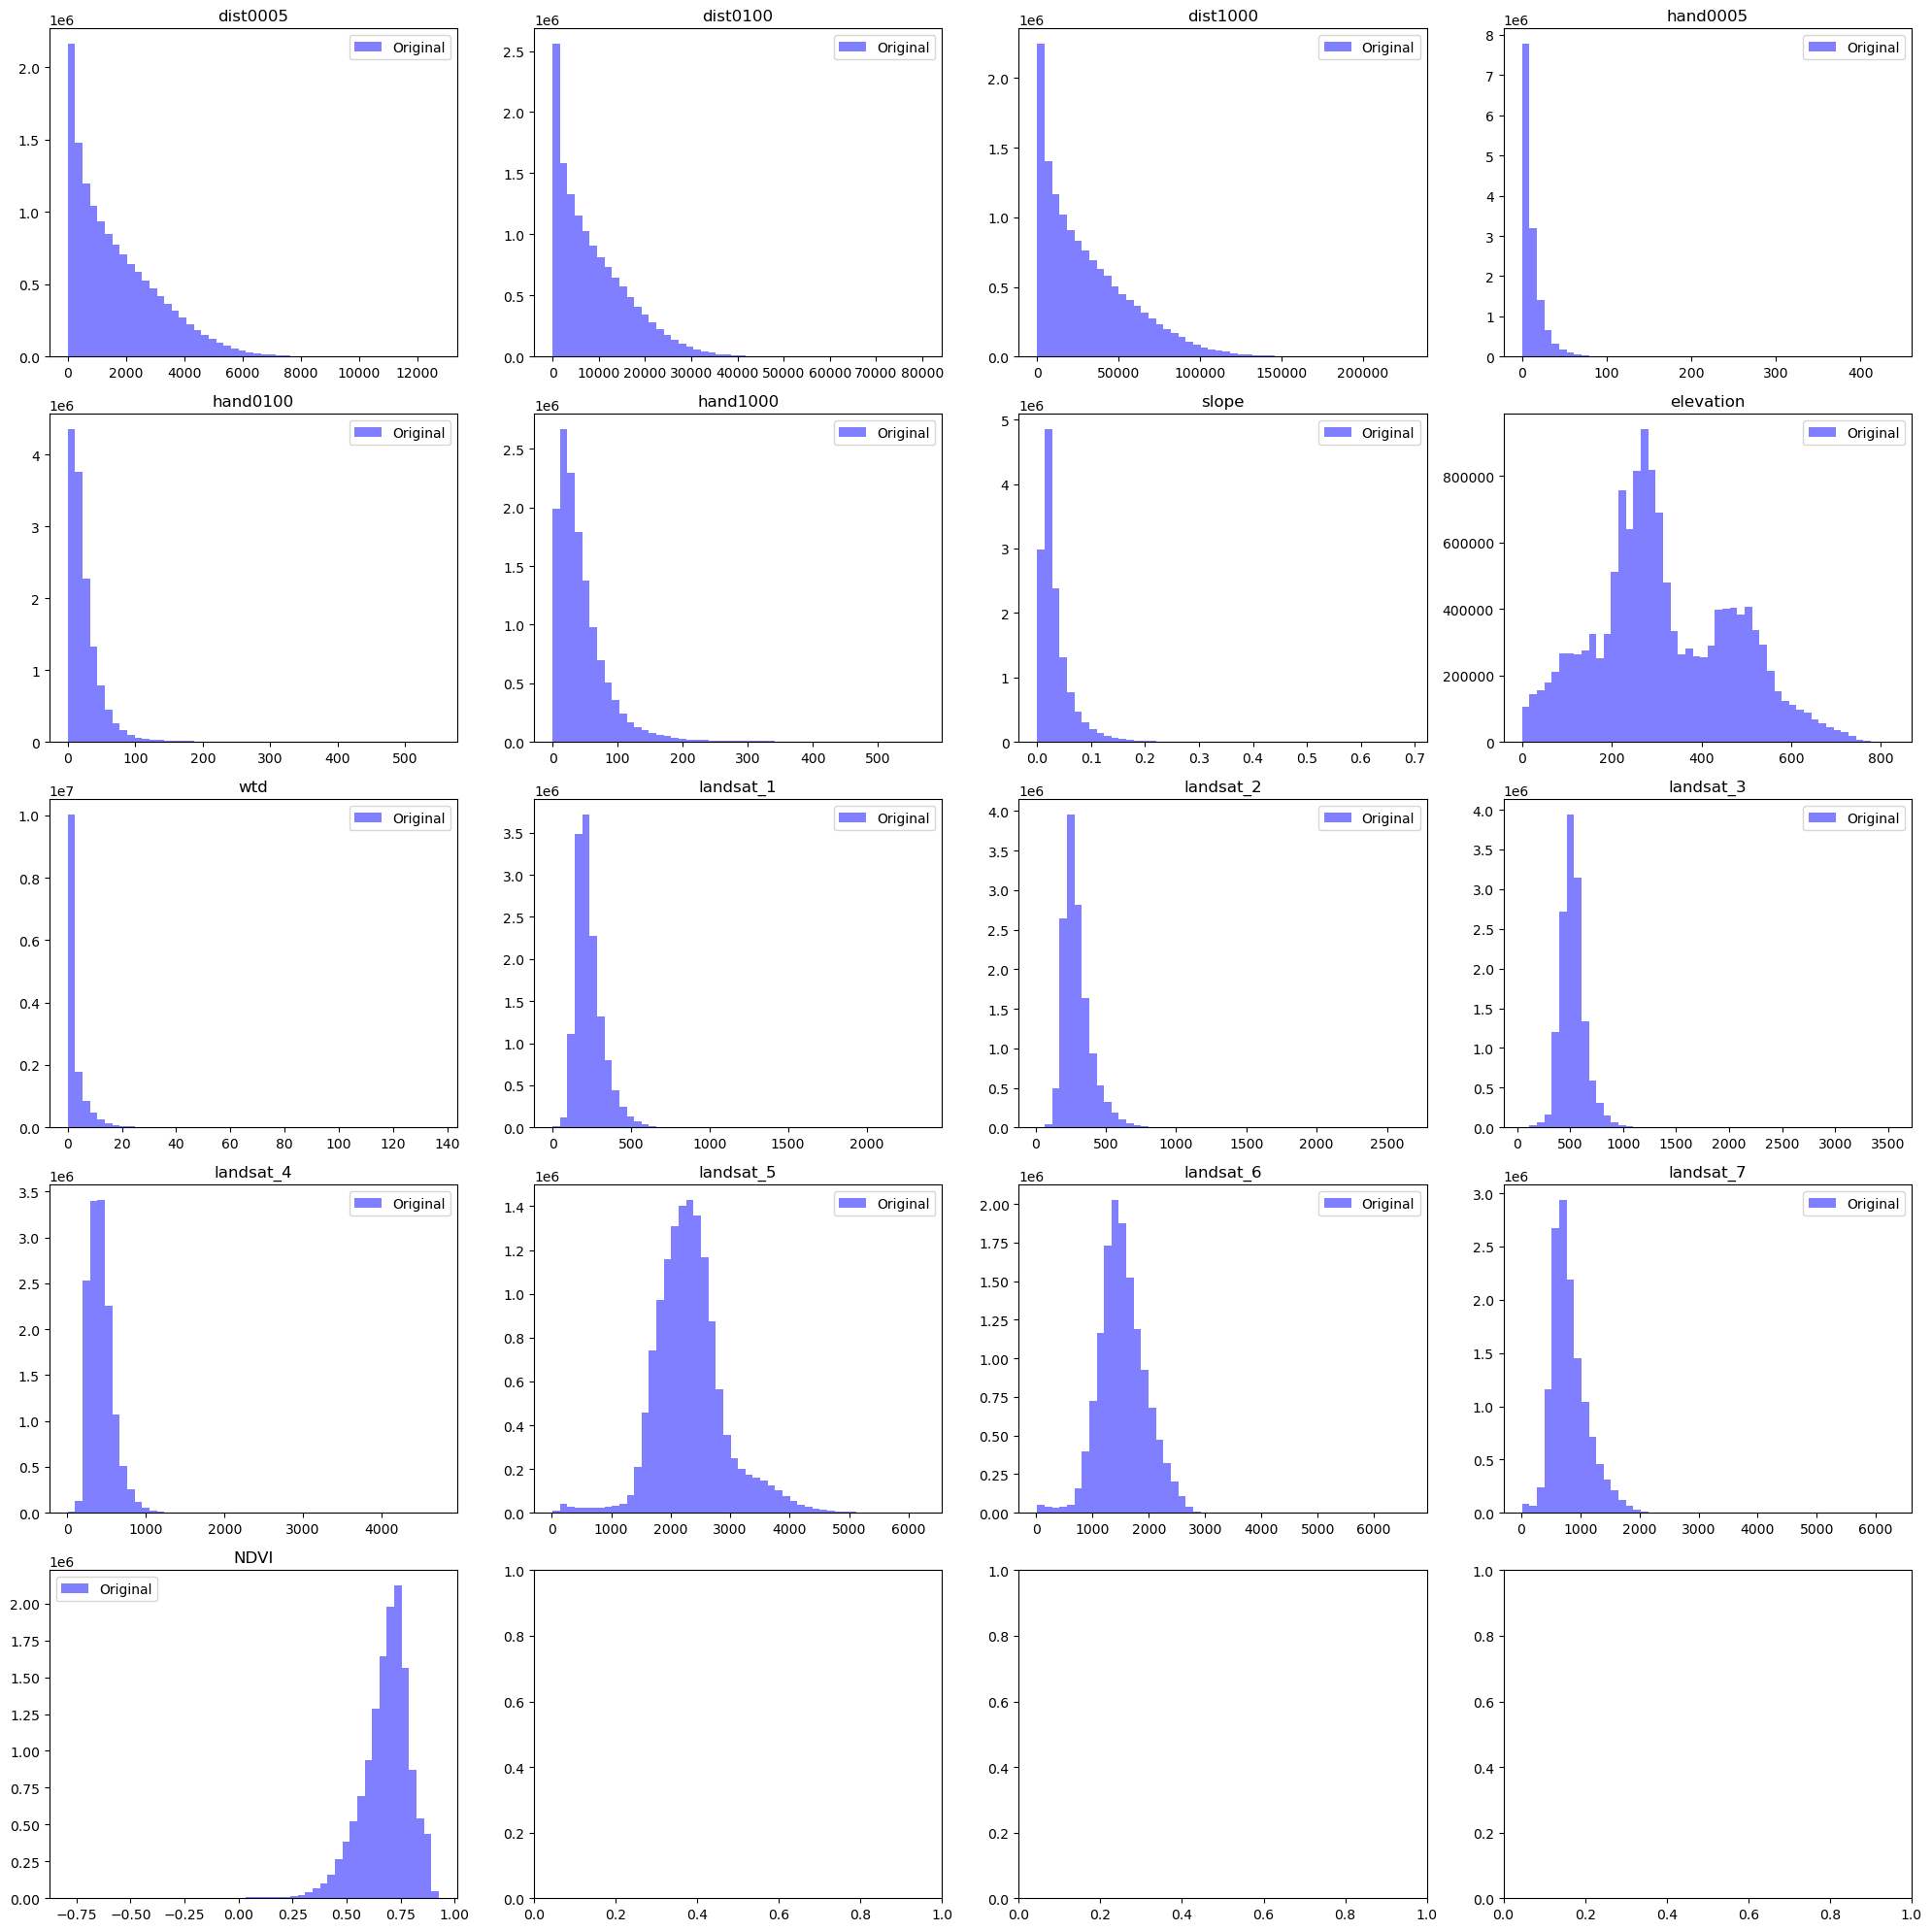

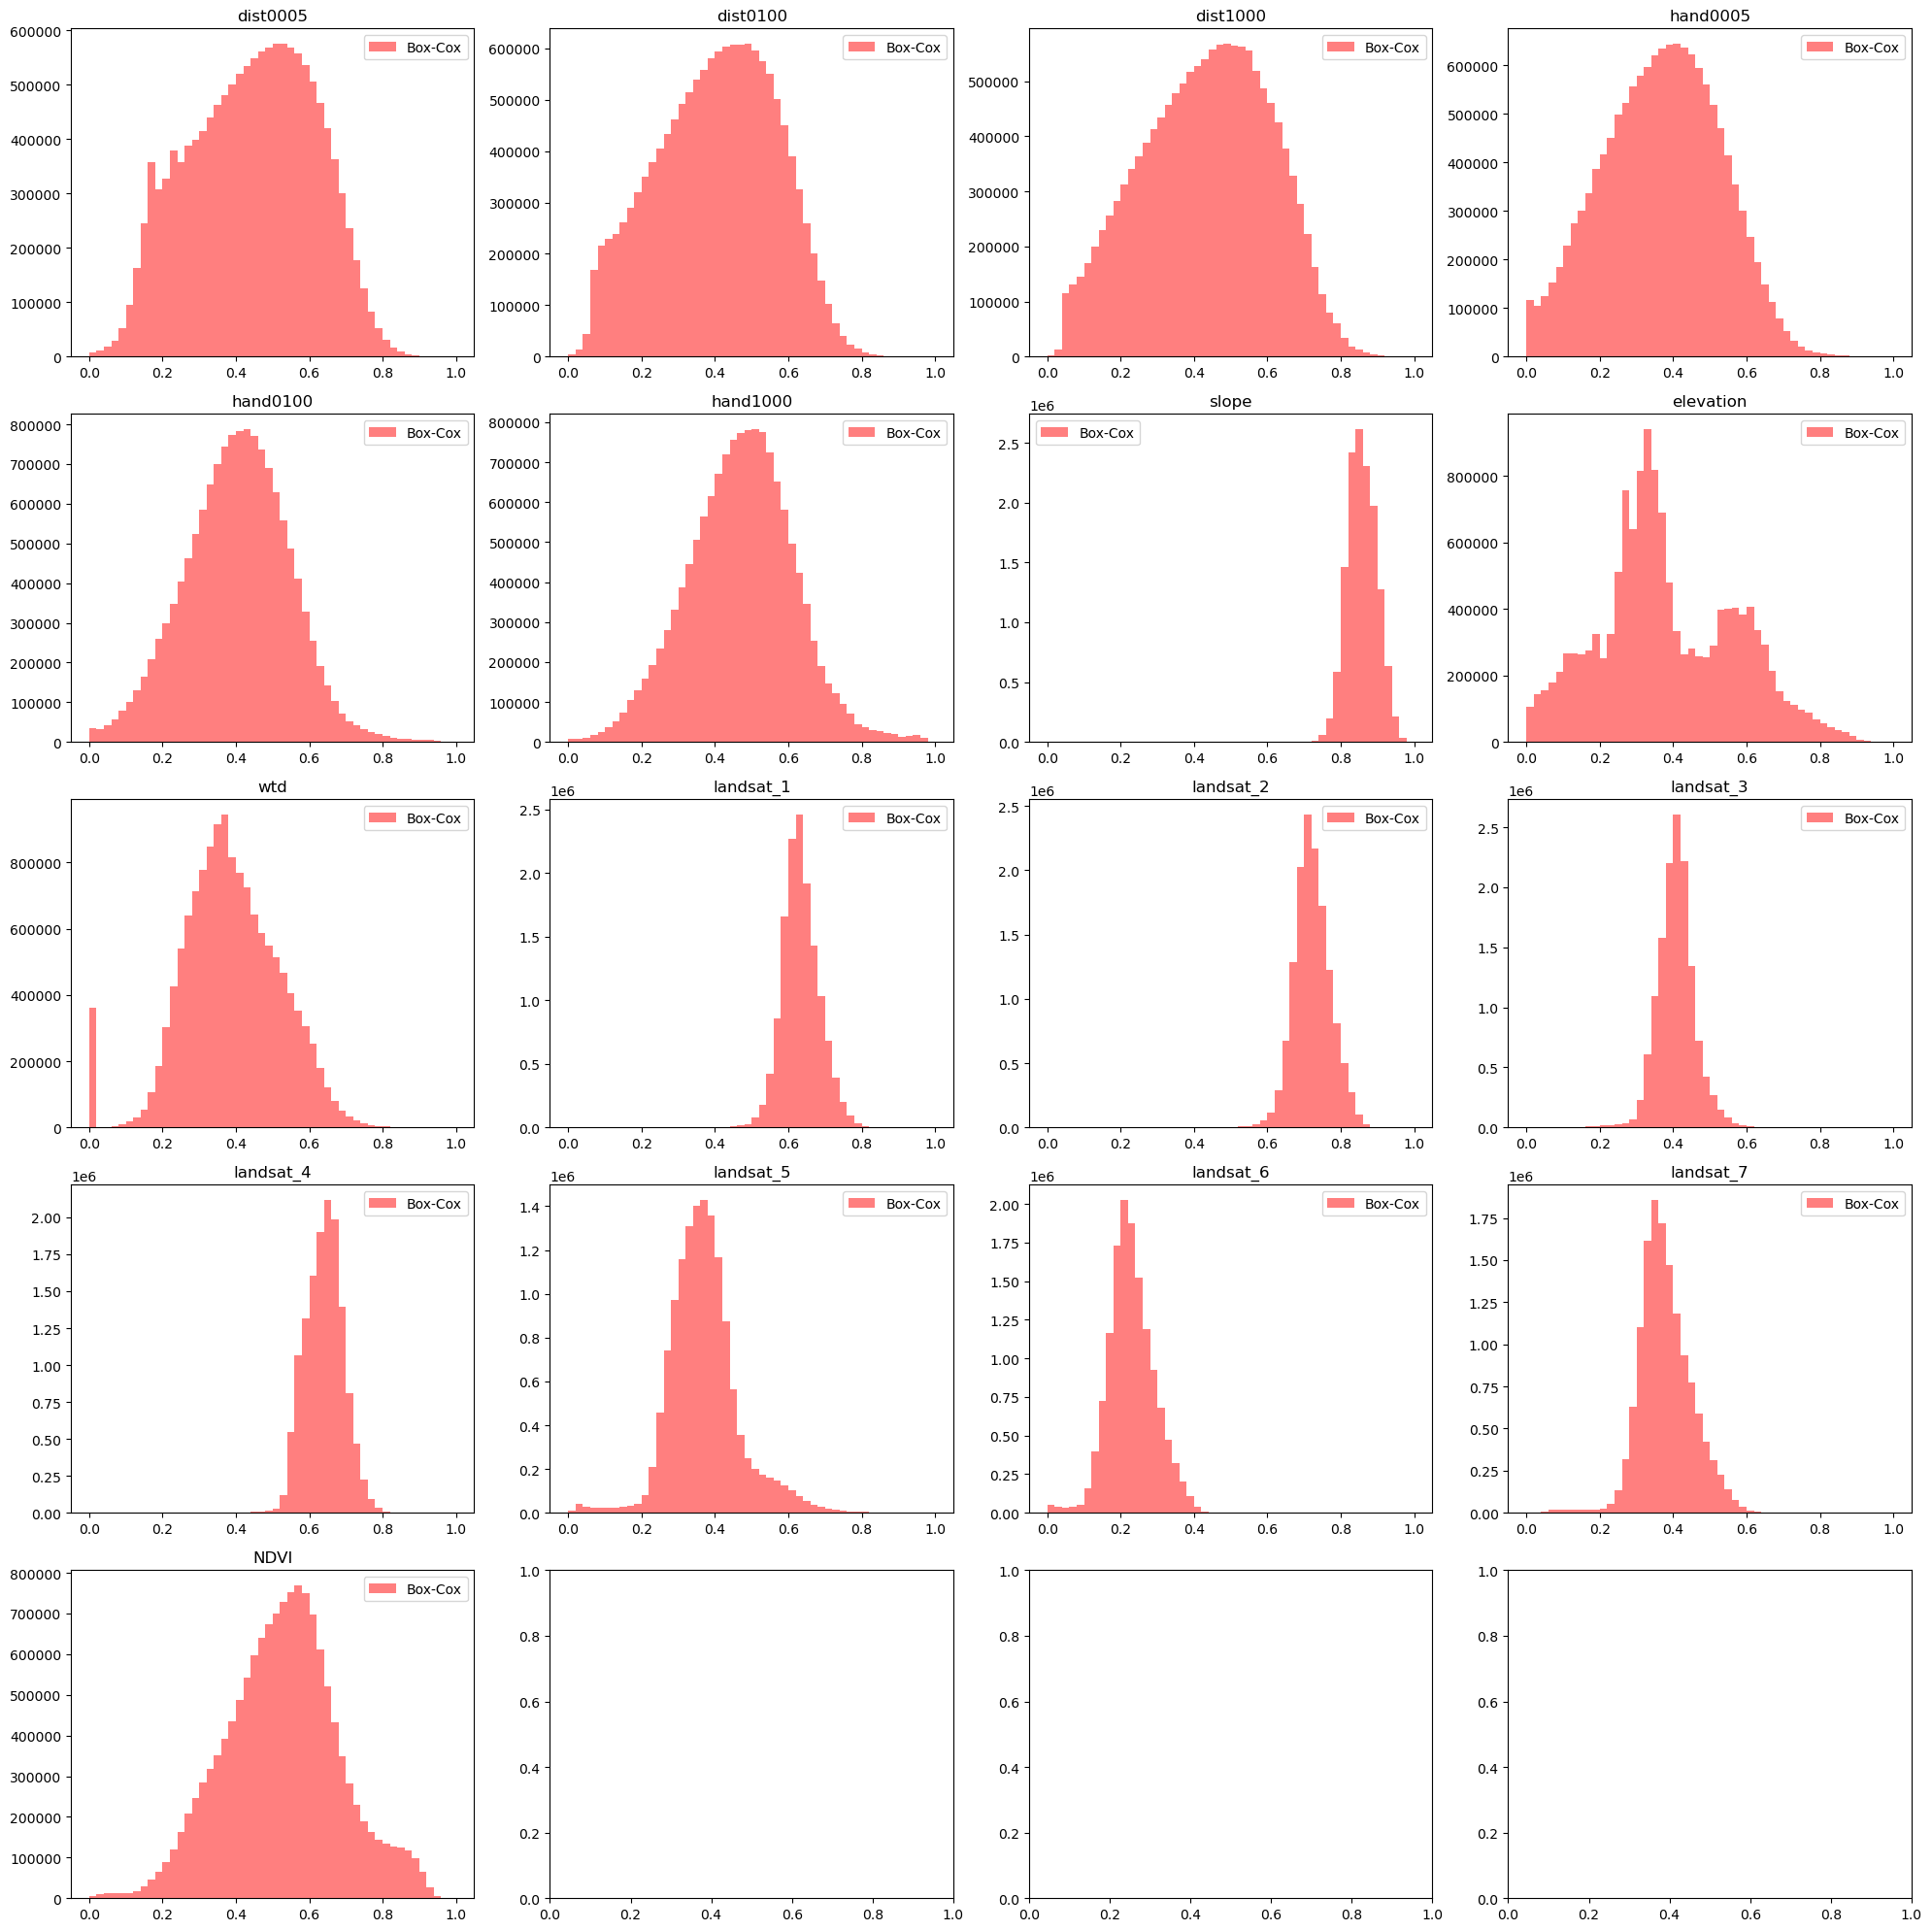

In [3]:


# Plot histograms of X and y

nb_fields = len(X_fields)
n_cols = 4
n_rows = nb_fields // n_cols + 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))

for i, field in enumerate(X_fields):
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col]
    ax.hist(X[field], bins=50, alpha=0.5, color='blue')
    ax.set_title(field)
    ax.legend(['Original'])
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))
for i, field in enumerate(X_fields):
    row = i // n_cols
    col = i % n_cols
    ax = axs[row, col]
    # Overlay the Box-Cox transformed data
    ax.hist(X_scaled[field], bins=50, alpha=0.5, color='red')
    ax.legend(['Box-Cox'])
    ax.set_title(field)
plt.tight_layout()
plt.show()


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
# Check the sizes of the resulting datasets
print("\t - Train dataset size:", len(X_train))
print("\t - Validation dataset size:", len(X_val))
print("\t - Test dataset size:", len(X_test))


# Define model parameters
input_size = list(X_train.shape)[1]
output_size = list(y_train.shape)[1] if len(y_train.shape) > 1 else 1

# Convert to tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

print("Creating DataLoaders...")

# Create DataLoader
train_loader = Data.DataLoader(train_dataset, batch_size=128, shuffle=True)
validate_loader = Data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = Data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Free some memory
del X_train, X_val, X_test, y_train, y_val, y_test
del X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor


print(f"Input size: {input_size}")
print(f"Output size: {output_size}")

	 - Train dataset size: 9641788
	 - Validation dataset size: 2066097
	 - Test dataset size: 2066098
Creating DataLoaders...
Input size: 17
Output size: 1


In [6]:
from peatnet import *
# Create the model
model = PeatNet(input_size, hidden_size, output_size).to(device)
# Number of parameters
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
# Summurize the model
print(model)

print("-."*50)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
print("Start training the model...")
total_time = train_model(model, train_loader, validate_loader, 
                         criterion, optimizer, num_epochs=num_epochs, device=device)


train_model(model, train_loader, validate_loader, criterion, 
            optimizer, num_epochs=10, device='cuda', scheduler=scheduler)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Save the model
print(f"Saving the model... to model{current_time}.ckpt")
torch.save(model.state_dict(), f"model{current_time}.ckpt")

# Test the model
print("Testing the model...")
val_loss = 0.0
with torch.no_grad():
    for inputs, targets in tqdm(validate_loader, desc='Final Validation', leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item()
avg_val_loss = val_loss / len(validate_loader)
print(f'Final Validation Loss: {avg_val_loss:.4f}')

end = datetime.datetime.now()
total_training_time = (end-start).total_seconds()
print(f"Duration of the script: {end-start}")

# Estimating the carbon footprint
power_consumption_gpu = 300  # watts
power_consumption_cpu = 150  # watts
carbon_intensity = 0.32  # kg CO2 per kWh (estimation for France in 2023)

if device.type == 'cpu':
    power_consumption = power_consumption_cpu
else:
    power_consumption = power_consumption_gpu

# Assuming the training was done on GPU
total_energy_kwh = (power_consumption / 1000) * (total_training_time / 3600)  # convert time to hours and power to kW
total_carbon_footprint = total_energy_kwh * carbon_intensity
print(f'Total energy consumed (estimated): {total_energy_kwh:.2f} kWh')
print(f'Total carbon footprint (estimated): {total_carbon_footprint:.2f} kg CO2')

Number of parameters: 1121
PeatNet(
  (fc1): Linear(in_features=17, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.
Start training the model...


Epoch 1/50:   0%|          | 0/75327 [00:00<?, ?it/s]

Epoch [1/50], Average Training Loss: 143.0251, Training MAE: 9.2694, Validation Loss: 129.0138, Validation MAE: 8.8213, Epoch Time: 232.53 seconds


Epoch [2/50], Average Training Loss: 123.1213, Training MAE: 8.6250, Validation Loss: 117.2291, Validation MAE: 8.3965, Epoch Time: 225.03 seconds


Epoch [3/50], Average Training Loss: 113.4833, Training MAE: 8.2958, Validation Loss: 110.0290, Validation MAE: 8.1317, Epoch Time: 225.18 seconds


Epoch [4/50], Average Training Loss: 108.2658, Training MAE: 8.0567, Validation Loss: 107.2471, Validation MAE: 7.9157, Epoch Time: 255.09 seconds


Epoch [5/50], Average Training Loss: 106.5176, Training MAE: 7.9774, Validation Loss: 106.1141, Validation MAE: 7.9447, Epoch Time: 279.54 seconds


Epoch [6/50], Average Training Loss: 105.2811, Training MAE: 7.9247, Validation Loss: 105.1624, Validation MAE: 7.9646, Epoch Time: 238.39 seconds


Epoch [7/50], Average Training Loss: 104.5407, Training MAE: 7.8907, Validation Loss: 103.9395, Validation MAE: 7.8307, Epoch Time: 230.93 seconds


Epoch [8/50], Average Training Loss: 104.0326, Training MAE: 7.8688, Validation Loss: 103.1617, Validation MAE: 7.8412, Epoch Time: 246.30 seconds


Epoch [9/50], Average Training Loss: 103.5844, Training MAE: 7.8483, Validation Loss: 103.1126, Validation MAE: 7.8293, Epoch Time: 240.52 seconds


Epoch [10/50], Average Training Loss: 103.1505, Training MAE: 7.8280, Validation Loss: 102.9344, Validation MAE: 7.8299, Epoch Time: 238.58 seconds


Epoch [11/50], Average Training Loss: 102.8107, Training MAE: 7.8108, Validation Loss: 102.2888, Validation MAE: 7.7640, Epoch Time: 237.46 seconds


Epoch [12/50], Average Training Loss: 102.4847, Training MAE: 7.7956, Validation Loss: 101.9922, Validation MAE: 7.7589, Epoch Time: 245.18 seconds


Epoch [13/50], Average Training Loss: 102.2214, Training MAE: 7.7836, Validation Loss: 101.8011, Validation MAE: 7.7249, Epoch Time: 263.47 seconds


Epoch [14/50], Average Training Loss: 101.9775, Training MAE: 7.7729, Validation Loss: 101.0120, Validation MAE: 7.7288, Epoch Time: 271.52 seconds


Epoch [15/50], Average Training Loss: 101.7078, Training MAE: 7.7619, Validation Loss: 102.9280, Validation MAE: 7.8646, Epoch Time: 242.11 seconds


Epoch [16/50], Average Training Loss: 101.4845, Training MAE: 7.7524, Validation Loss: 100.8697, Validation MAE: 7.7597, Epoch Time: 235.17 seconds


Epoch [17/50], Average Training Loss: 101.1868, Training MAE: 7.7391, Validation Loss: 101.1266, Validation MAE: 7.7205, Epoch Time: 235.50 seconds


Epoch [18/50], Average Training Loss: 100.8579, Training MAE: 7.7223, Validation Loss: 100.9594, Validation MAE: 7.7052, Epoch Time: 237.67 seconds


Epoch [19/50], Average Training Loss: 100.6027, Training MAE: 7.7097, Validation Loss: 102.0396, Validation MAE: 7.7498, Epoch Time: 236.97 seconds


Epoch [20/50], Average Training Loss: 100.3534, Training MAE: 7.6988, Validation Loss: 100.0317, Validation MAE: 7.6993, Epoch Time: 253.59 seconds


Epoch [21/50], Average Training Loss: 100.1281, Training MAE: 7.6873, Validation Loss: 99.5547, Validation MAE: 7.6473, Epoch Time: 248.40 seconds


Epoch [22/50], Average Training Loss: 99.9235, Training MAE: 7.6781, Validation Loss: 100.5782, Validation MAE: 7.7663, Epoch Time: 254.42 seconds


Epoch [23/50], Average Training Loss: 99.7575, Training MAE: 7.6704, Validation Loss: 99.5817, Validation MAE: 7.6367, Epoch Time: 241.83 seconds


Epoch [24/50], Average Training Loss: 99.6240, Training MAE: 7.6647, Validation Loss: 99.5874, Validation MAE: 7.7253, Epoch Time: 231.90 seconds


Epoch [25/50], Average Training Loss: 99.4963, Training MAE: 7.6595, Validation Loss: 98.7528, Validation MAE: 7.6455, Epoch Time: 236.56 seconds


Epoch [26/50], Average Training Loss: 99.3989, Training MAE: 7.6561, Validation Loss: 98.6998, Validation MAE: 7.5844, Epoch Time: 236.02 seconds


Epoch [27/50], Average Training Loss: 99.3056, Training MAE: 7.6528, Validation Loss: 100.3167, Validation MAE: 7.7147, Epoch Time: 231.28 seconds


Epoch [28/50], Average Training Loss: 99.2131, Training MAE: 7.6487, Validation Loss: 99.0575, Validation MAE: 7.6834, Epoch Time: 230.75 seconds


Epoch [29/50], Average Training Loss: 99.1120, Training MAE: 7.6442, Validation Loss: 98.6681, Validation MAE: 7.6411, Epoch Time: 231.21 seconds


Epoch [30/50], Average Training Loss: 99.0190, Training MAE: 7.6400, Validation Loss: 98.4185, Validation MAE: 7.6093, Epoch Time: 229.47 seconds


Epoch [31/50], Average Training Loss: 98.9288, Training MAE: 7.6373, Validation Loss: 98.3133, Validation MAE: 7.5910, Epoch Time: 226.07 seconds


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
